# Recommendation System using Electronics data

#### Context : 
Everyday a million products are being recommended to users based on popularity and other metrics on e-commerce websites. The most popular e-commerce website boosts average order value by 50%, increases revenues by 300%, and improves conversion. In addition to being a powerful tool for increasing revenues, product recommendations are so essential that customers now expect to see similar features on all other eCommerce sites.

#### Data source : 
The dataset used here is a Kaggle competition dataset for Electronic products rated on Amazon. https://www.kaggle.com/saurav9786/amazon-product-reviews

#### Data description : 
First three columns are userId, productId, and ratings and the fourth column is timestamp.

#### Objective :
To make a recommendation system that recommends at least five(5) new products based on the user's habits.


In [1]:
import pandas as pd
import numpy as np
import math

# import the visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import surprise package
from surprise import KNNWithMeans, SVD
from surprise import accuracy
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

# For SVD
from sklearn.decomposition import TruncatedSVD

## 1. Read and explore given dataset

### Load as pandas dataframe by providing column names

In [2]:
products_df = pd.read_csv("ratings_Electronics.csv", names=['userId', 'productId', 'ratings','timestamp'])

In [3]:
products_df.shape

(7824482, 4)

The dataset has 7824482 records with 4 columns

#### Drop the 'timestamp' column

In [4]:
products_df = products_df.drop('timestamp', axis=1)

In [5]:
products_df.head(5)

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [6]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [7]:
products_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [8]:
repeated_records = products_df.duplicated()
print('Total number of repeated records :',sum(repeated_records))

Total number of repeated records : 0


In [9]:
products_df.isnull().sum()

userId       0
productId    0
ratings      0
dtype: int64

There are no missing values in the data

In [10]:
products_df.count()

userId       7824482
productId    7824482
ratings      7824482
dtype: int64

In [11]:
products_df['userId'].nunique()

4201696

There are 4201696 unique users in the data

In [12]:
products_df['productId'].nunique()

476002

There are 476002 unique products in the data

#### Plot the number of ratings

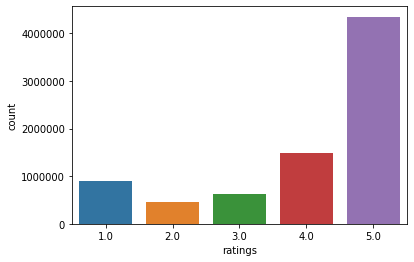

In [13]:
sns.countplot(products_df['ratings'])

#### Takeaway : 
Most of the records in the data have 5 rating.

## 2. Take a subset of dataset to make it less sparse/ denser

### Select only users who have rated 50 or more products

In [14]:
product_df_subset = products_df[products_df['userId'].map(products_df['userId'].value_counts()) >= 50]

In [15]:
product_df_subset.count()

userId       125871
productId    125871
ratings      125871
dtype: int64

In [16]:
product_df_subset['userId'].nunique()

1540

In [17]:
product_df_subset['productId'].nunique()

48190

## 3. Popularity Based Recommender Model

#### Popularity based recommendation model recommends the products that are purchased by most of the users and are higly rated.
#### Therefore, we will get a mean value of the ratings for each product along with number of times it is purchased.

In [18]:
product_grouped_ratings = product_df_subset.groupby('productId').ratings.agg(['mean', 'count']).reset_index()

In [19]:
product_grouped_ratings

,productId,mean,count
0,0594451647,5.000000,1
1,0594481813,3.000000,1
2,0970407998,2.500000,2
3,0972683275,4.750000,4
4,1400501466,3.333333,6
...,...,...,...
48185,B00LED02VY,4.000000,1
48186,B00LGN7Y3G,5.000000,1
48187,B00LGQ6HL8,5.000000,5
48188,B00LI4ZZO8,4.500000,2


#### Plot the distribution of the mean ratings

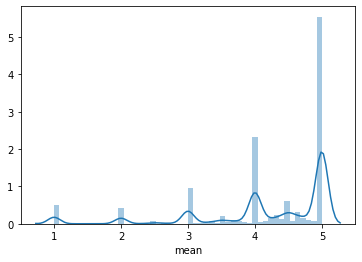

In [20]:
sns.distplot(product_grouped_ratings['mean'])

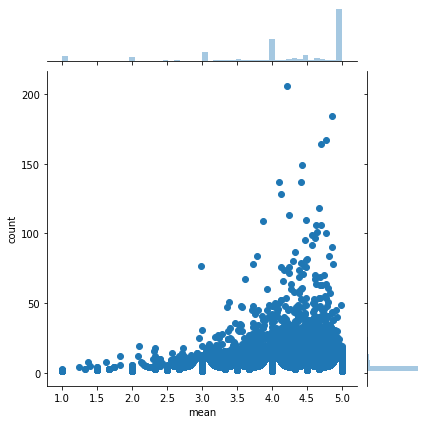

In [21]:
sns.jointplot(x='mean', y='count', data=product_grouped_ratings)

#### Takeaway : 
The mean ratings mostly lie between 4 and 5.

#### Sort based on the count of ratings and mean ratings to get top products

In [22]:
product_grouped_ratings = product_grouped_ratings.sort_values(['count','mean'], ascending=False).reset_index()

#### Recommend top 20 products which are most bought and highly rated

In [23]:
top_20_products = product_grouped_ratings[:20]
print(top_20_products["productId"])

0     B0088CJT4U
1     B003ES5ZUU
2     B000N99BBC
3     B007WTAJTO
4     B00829TIEK
5     B00829THK0
6     B008DWCRQW
7     B002R5AM7C
8     B004CLYEDC
9     B002SZEOLG
10    B00834SJNA
11    B004T9RR6I
12    B002V88HFE
13    B0034CL2ZI
14    B00834SJSK
15    B002WE6D44
16    B00829TIA4
17    B004CLYEFK
18    B009SYZ8OC
19    B0079UAT0A
Name: productId, dtype: object


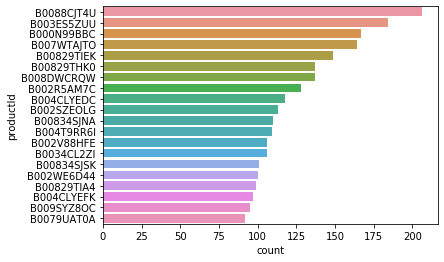

In [24]:
sns.barplot(y='productId',x='count', data = top_20_products)

### 4. Split into train and test set

#### Read the data as a 'Suprise' dataset

In [25]:
reader = Reader()
products_data = Dataset.load_from_df(product_df_subset,reader)

#### Split train test into 70:30 ratio

In [26]:
train_set, test_set = train_test_split(products_data, test_size=0.3)

### 5. Build Collaborative Filtering Model

### Build a Memory-based Collaborative Filtering model

#### We want to recommend products based on user habits. A user-user collaborative filtering model would be helpful here. 

In [27]:
cf_algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
cf_algo.fit(train_set)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


#### Take an example user for the predictions

In [28]:
user_index = 50

In [29]:
test_set[user_index]

('A96JD9312DHWC', 'B004GKM9SG', 3.0)

In [30]:
userid = test_set[user_index][0]
productid = test_set[user_index][1]

In [31]:
# get a prediction for specific user and product
pred = cf_algo.predict(userid, productid, verbose=True)

user: A96JD9312DHWC item: B004GKM9SG r_ui = None   est = 4.66   {'actual_k': 0, 'was_impossible': False}


### 6. Evaluate the model

In [32]:
# test model on test_set
test_pred = cf_algo.test(test_set)

In [33]:
# Print only top 5 predictions for brevity
test_pred[:5]

[Prediction(uid='A3OA4DV4L81N1D', iid='B0039ZBEBM', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AUCIFMWP3DU8R', iid='B0000AZK0D', r_ui=5.0, est=3.888888888888889, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='ACY9QYNDFLVBI', iid='B005CT56F8', r_ui=5.0, est=4.727075196204169, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A2I6GN7OHB9JKF', iid='B002P8JVAK', r_ui=5.0, est=4.260631717531694, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B003XDU2Y0', r_ui=5.0, est=4.5, details={'actual_k': 0, 'was_impossible': False})]

#### Get RMSE for User-based model

In [34]:
print("RMSE for User-based Model on Test set : ")
print(accuracy.rmse(test_pred, verbose=True))

RMSE for User-based Model on Test set : 
RMSE: 1.0568
1.0567595548147453


### 7. Get Top-K (K=5) recommendations

#### Since the matrix is very sparse, we can build a collaborative filtering model using model-based approach to get the Top-K recommendations. 
#### Model-based Collaborative Filtering approach is better in terms of providing more number of recommendations per user. 

### Model-based Collaborative Filtering using SVD

#### Taking only 10% of the data due to memory constraints

In [35]:
# Get number of records needed to for 10% of the dataset
count_10perc = math.floor(product_df_subset['userId'].count() * 0.1)
count_10perc

12587

In [36]:
product_df_10perc = product_df_subset[:count_10perc]

In [37]:
product_df_10perc.count()

userId       12587
productId    12587
ratings      12587
dtype: int64

#### Create a matrix of the ratings with productId as row index and userId as columns

In [38]:
ratings_mat = product_df_10perc.pivot_table(values='ratings', index='productId', columns='userId', fill_value=0)
ratings_mat.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105TOJ6LTVMBG,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,A10Y058K7B96C6,A10ZBR6O8S8OCY,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0594481813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0970407998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0972683275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
ratings_mat.shape

(6440, 1431)

#### Create an SVD using dimensionality reduction, due to high sparsity of the matrix

In [40]:
# Reduce dimensionality to 50 components
SVD = TruncatedSVD(n_components=50)
svd = SVD.fit_transform(ratings_mat)

In [41]:
svd

array([[ 6.69597769e-03,  2.47070875e-02, -5.81681808e-03, ...,
         4.81341580e-03,  4.24159624e-04, -1.30055171e-02],
       [ 1.28164760e-03,  8.99009149e-04,  3.58684625e-04, ...,
        -1.43593838e-02,  1.84995875e-02,  9.79706519e-03],
       [ 1.37727024e-02,  1.94524340e-02,  4.95512897e-03, ...,
         1.28986911e-01, -8.07864486e-02,  8.94448701e-03],
       ...,
       [ 5.25471617e-03,  1.81988355e-03,  7.81293243e-04, ...,
        -3.43408920e-01, -1.63703097e-01,  4.04173987e-02],
       [ 8.32073266e-02, -1.19593073e-03, -3.04378185e-03, ...,
         1.04438927e+00,  3.62692352e-01, -1.06036843e-02],
       [ 3.12026576e-02, -1.14574521e-02,  8.01821395e-04, ...,
        -6.89086029e-02, -1.83134570e-02, -4.40143881e-02]])

#### Create a correlation matrix for the products

In [42]:
corr = np.corrcoef(svd)

In [43]:
corr

array([[ 1.00000000e+00,  1.16189311e-02, -5.62056631e-04, ...,
         4.36339028e-02,  2.84973245e-01, -3.08518209e-02],
       [ 1.16189311e-02,  1.00000000e+00,  9.41743219e-02, ...,
         1.12925591e-01,  8.36546615e-02, -2.48309766e-01],
       [-5.62056631e-04,  9.41743219e-02,  1.00000000e+00, ...,
         4.85112338e-02,  1.42143531e-01, -9.40950624e-02],
       ...,
       [ 4.36339028e-02,  1.12925591e-01,  4.85112338e-02, ...,
         1.00000000e+00, -9.00324436e-02,  2.87176417e-01],
       [ 2.84973245e-01,  8.36546615e-02,  1.42143531e-01, ...,
        -9.00324436e-02,  1.00000000e+00, -1.41439937e-01],
       [-3.08518209e-02, -2.48309766e-01, -9.40950624e-02, ...,
         2.87176417e-01, -1.41439937e-01,  1.00000000e+00]])

#### Take an example productId for recommendation

In [44]:
product_index = 1000

In [45]:
selected_product = ratings_mat.index[product_index]
selected_product

'B00005BKZZ'

#### Subset correlation matrix on the selected product

In [46]:
product_corr_value = corr[product_index]

In [47]:
product_corr_value

array([ 0.38358664, -0.03089804,  0.02606574, ..., -0.02342347,
       -0.02167455, -0.05088597])

#### Get products that are having a correlation coefficient of more than 0.75 to get the most relevant products

In [48]:
recommend_products = list(ratings_mat.index[product_corr_value > 0.75])

#### We need to remove the selected product from the list as it is already bought by the user

In [49]:
recommend_products.remove(selected_product)

#### Get top 5 products for a user based on purchases made by other users 

In [50]:
k = 5

In [51]:
recommend_products[:k]

['B00000J1US', 'B00000J570', 'B00000JFJA', 'B00000JSGF', 'B00000K4KH']

### 8. Summary

#### 1. Popularity based recommendations can be used to recommend top purchased and rated products. However, this approach cannot be used for personalized recommendations.

#### 2. Collaborative filtering using memory-based approach can be used for user-based recommendations. The 'KNNwithMeans' method can be tuned for better cluster configurations. There are other methods available from 'Surprise' package for user-user collaborative filtering as well.

#### 3. A model-based approach for collaborative filtering based on SVD can also be built for top-k recommendations. 

#### The top 5 products recommended for a user who purchased product 'B00005BKZZ' are : 
#### 'B00000J1US', 'B00000J570', 'B00000JFJA', 'B00000JSGF', 'B00000K4KH'